# Trial History and Replay

This guide will give a breif overview of the history returned by a `Trial` from a call to fit or evaluate.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup.

## Install Torchbearer

First we install torchbearer if needed.

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.4.0.dev


## A Simple Example

We first create some data and a simple model to train on.

In [2]:
import torch
import torch.nn as nn

class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.linear1 = nn.Linear(100, 25)
        self.linear2 = nn.Linear(25, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return torch.sigmoid(x).squeeze(1)
    
from torch.utils.data import TensorDataset, DataLoader


import numpy as np
from sklearn.datasets.samples_generator import make_blobs

X, Y = make_blobs(n_samples=2048, n_features=100, centers=2, cluster_std=10, random_state=1)
X = (X - X.mean()) / X.std()
Y[np.where(Y == 0)] = -1
X, Y = torch.FloatTensor(X), torch.FloatTensor(Y)
traingen = DataLoader(TensorDataset(X, Y), batch_size=128)

Next, we'll run the model for a few epochs to obtain a history.

In [3]:
import torch.optim as optim
import torch.nn.functional as F

from torchbearer import Trial

model = BasicModel()

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
trial = Trial(model, optimizer=optimizer, criterion=F.binary_cross_entropy,
                          metrics=['mse', 'acc', 'loss'])
trial.with_train_generator(traingen)
history = trial.run(epochs=20, verbose=1)

## The History

The history is a list of metric dictionaries from each epoch of training. History also includes the number of training and validation steps from each epoch. Let's take a look

In [4]:
print(len(history))
print(history[5])

20
{'running_mse': 0.9208962321281433, 'running_binary_acc': 0.960156261920929, 'running_loss': -0.019676249474287033, 'mse': 0.8676411509513855, 'binary_acc': 0.96923828125, 'loss': -0.15272381901741028, 'train_steps': 16, 'validation_steps': None}


### With Pandas
Suppose that we wanted to use pandas to plot our training progress or similar, we could do that with the following

In [5]:
import pandas as pd

frame = pd.DataFrame.from_records(history)
print(frame)

    binary_acc      loss       mse  running_binary_acc  running_loss  \
0     0.896484  0.316458  1.067553            0.887784      0.334222   
1     0.923340  0.225443  1.025509            0.904803      0.286757   
2     0.939453  0.133693  0.984494            0.916061      0.240595   
3     0.953613  0.040475  0.944467            0.933594      0.167838   
4     0.963867 -0.054826  0.905476            0.949063      0.074993   
5     0.969238 -0.152724  0.867641            0.960156     -0.019676   
6     0.973633 -0.253658  0.831138            0.967812     -0.116728   
7     0.978027 -0.358019  0.796175            0.972656     -0.216635   
8     0.979004 -0.466167  0.762976            0.975781     -0.319814   
9     0.980469 -0.578459  0.731756            0.978750     -0.426640   
10    0.981445 -0.695270  0.702708            0.980313     -0.537480   
11    0.984375 -0.817010  0.675986            0.982188     -0.652704   
12    0.983887 -0.944141  0.651693            0.983594     -0.77

We can now use all of the built-in pandas functions, such as plotting

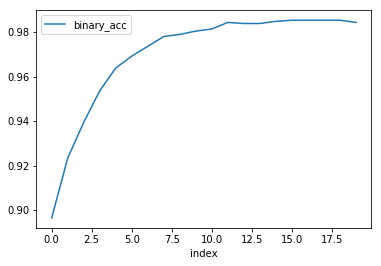

In [6]:
%matplotlib inline
frame.reset_index().plot('index', 'binary_acc')

## Replay a Trial

One of the perks of history is the ability to replay a trial. We'll look at two of the replay options here. First we can just replay the whole training process, this time with a different verbosity.

In [7]:
_ = trial.replay(verbose=2)

This may be more output than we desire, and so we can instead use the `one_batch` flag to just simulate one batch per epoch.

In [8]:
_ = trial.replay(verbose=2, one_batch=True)

So that's history and replaying in `torchbearer`. Be sure to have a look at our other examples at [pytorchbearer.org](http://www.pytorchbearer.org/).